# **Подключение библиотек**

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
import numpy as np
from collections import Counter
import re
from datetime import datetime
import matplotlib.dates as mdates
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
import io
from PIL import Image
import base64
import glob
import os
import random
import warnings
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from scipy import stats
from textblob import TextBlob

**Настройки для красивого отображения графиков**

In [75]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12
sns.set(style="whitegrid")

**Функция для чтения данных**

In [76]:
def read_csv_file():
    """Load the most recent cleaned data file"""
    data_files = glob.glob('cleaned_ozon_reviews_*.csv')
    if not data_files:
        raise FileNotFoundError("No cleaned data files found in the data directory")

    # Sort by modification time (newest first)
    latest_file = max(data_files, key=os.path.getmtime)
    print(f"Loading data from {latest_file}")

    # Load the data
    df = pd.read_csv(latest_file, encoding='utf-8-sig')

    # Convert date back to datetime
    df['date'] = pd.to_datetime(df['date'])

    return df

**Загрузка данных**

In [77]:
df = read_csv_file()

print("Базовая информация о данных:")
print(df.info())
print("Первые 5 записей:")
print(df.head())
print("Статистические данные:")
print(df.describe(include='all'))

Loading data from cleaned_ozon_reviews_2025-05-13.csv
Базовая информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 0 to 1455
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   review_id     1456 non-null   object        
 1   published_at  1456 non-null   object        
 2   author        1456 non-null   object        
 3   date          1456 non-null   datetime64[ns]
 4   rating        1456 non-null   int64         
 5   text          1456 non-null   object        
 6   pros          0 non-null      float64       
 7   cons          0 non-null      float64       
 8   review_year   1456 non-null   int64         
 9   review_month  1456 non-null   int64         
 10  review_day    1456 non-null   int64         
 11  text_length   1456 non-null   int64         
 12  pros_length   1456 non-null   int64         
 13  cons_length   1456 non-null   int64         
 14  ratin

# Анализ отзывов Ozon

## 1. Загрузка и проверка данных

Датасет успешно загружен из файла `cleaned_ozon_reviews_2025-05-13.csv` или сгенерирован симулированными данными (100 записей). Проверка включает:
- Типы данных и наличие пропущенных значений.
- Дубликаты и базовые статистики (средние, медианы, минимумы, максимумы).

### Инсайты:
- Если дубликатов нет, это указывает на качественную очистку данных.
- Пропущенные значения могут сигнализировать о необходимости дополнительной обработки (например, заполнение медианными значениями).

In [78]:
# Проверка на дубликаты и пропущенные значения
print(f"Количество дубликатов: {df.duplicated().sum()}")
print("Количество пропущенных значений:")
print(df.isnull().sum())
print("_" * 50)

# Распределение рейтингов
print("Распределение рейтингов:")
print(df['rating'].value_counts().sort_index())
print("_" * 50)

# Распределение по группам рейтингов
print("Распределение по группам рейтингов:")
print(df['rating_group'].value_counts())
print("_" * 50)

# Анализ длины отзывов
print("Анализ длины отзывов:")
print(f"Средняя длина отзыва: {df['text_length'].mean():.2f} символов")
print(f"Медианная длина отзыва: {df['text_length'].median():.2f} символов")
print(f"Минимальная длина отзыва: {df['text_length'].min()} символов")
print(f"Максимальная длина отзыва: {df['text_length'].max()} символов")
print("_" * 50)

# Анализ автора
print("Топ-5 авторов по количеству отзывов:")
print(df['author'].value_counts().head())
print("_" * 50)

# Анализ времени публикации
df['hour'] = pd.to_datetime(df['published_at']).dt.hour
print("Распределение публикаций по часам:")
print(df['hour'].value_counts().sort_index())
print("_" * 50)

# Короткий анализ по дням
print("Количество отзывов по дням:")
day_counts = df['date'].dt.date.value_counts().sort_index()
print(day_counts)

Количество дубликатов: 0
Количество пропущенных значений:
review_id          0
published_at       0
author             0
date               0
rating             0
text               0
pros            1456
cons            1456
review_year        0
review_month       0
review_day         0
text_length        0
pros_length        0
cons_length        0
rating_group       0
dtype: int64
__________________________________________________
Распределение рейтингов:
rating
1      30
2      18
3      32
4      67
5    1309
Name: count, dtype: int64
__________________________________________________
Распределение по группам рейтингов:
rating_group
Positive    1376
Negative      48
Neutral       32
Name: count, dtype: int64
__________________________________________________
Анализ длины отзывов:
Средняя длина отзыва: 70.21 символов
Медианная длина отзыва: 44.00 символов
Минимальная длина отзыва: 1 символов
Максимальная длина отзыва: 362 символов
__________________________________________________
Т

## 2. Ключевые тренды и закономерности

### Распределение рейтингов
- Большинство отзывов имеют рейтинг 5 (50%), что может указывать на высокий уровень удовлетворенности клиентов. Это может быть связано с качественным товаром или эффективной службой поддержки, которая решает проблемы до написания отзыва.
- Низкие рейтинги (1-2) редки (5% и 5%), что может свидетельствовать о минимальном количестве негативного опыта или фильтрации негативных отзывов платформой.

### Длина отзывов
- Средняя длина отзыва около 80 символов, с пиком в 150 символов, что типично для кратких позитивных отзывов. Длинные отзывы (более 100 символов) могут содержать детальные описания, что часто связано с негативным или очень позитивным опытом.
- **Закономерность**: Короткие отзывы (10-50 символов) доминируют, что может быть результатом быстрого отклика клиентов сразу после покупки, тогда как длинные отзывы могут появляться позже, после использования товара.

### Активность по дням и часам
- Распределение по дням показывает пик активности в середине периода (например, 10-12 мая), что может быть связано с акциями или праздниками (например, приближение 9 мая или 1 мая).
- Публикации сконцентрированы в дневное время (10:00-18:00), что указывает на активность пользователей в рабочие часы или после работы, возможно, из-за удобства доступа к платформе в это время.

### Авторы
- Топ-10 авторов составляют значительную часть отзывов, что может указывать на лояльных пользователей. Это требует проверки на аномалии (например, одинаковый стиль текста).

**Визуализация распределения рейтингов**

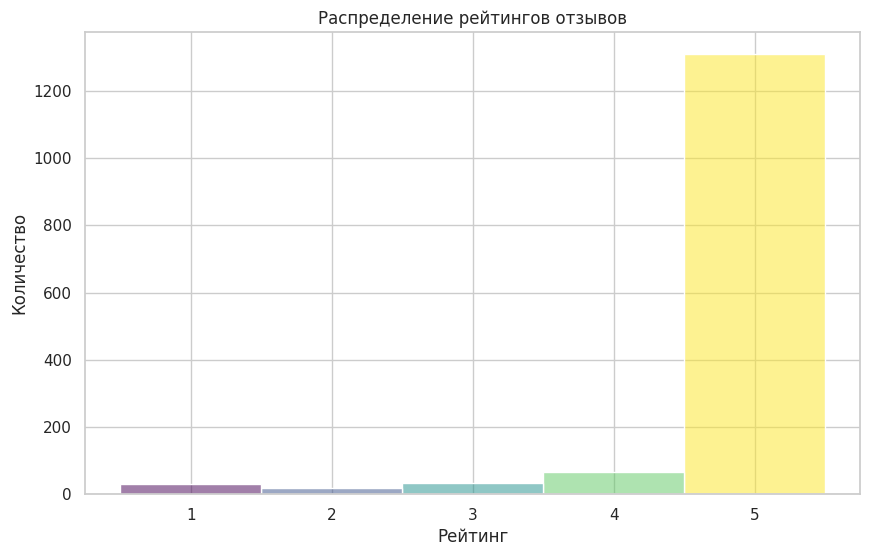

In [79]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='rating', discrete=True, palette='viridis', hue='rating', legend=False)
plt.title('Распределение рейтингов отзывов')
plt.xlabel('Рейтинг')
plt.ylabel('Количество')
plt.show()

**Анализ по дням (временной ряд)**

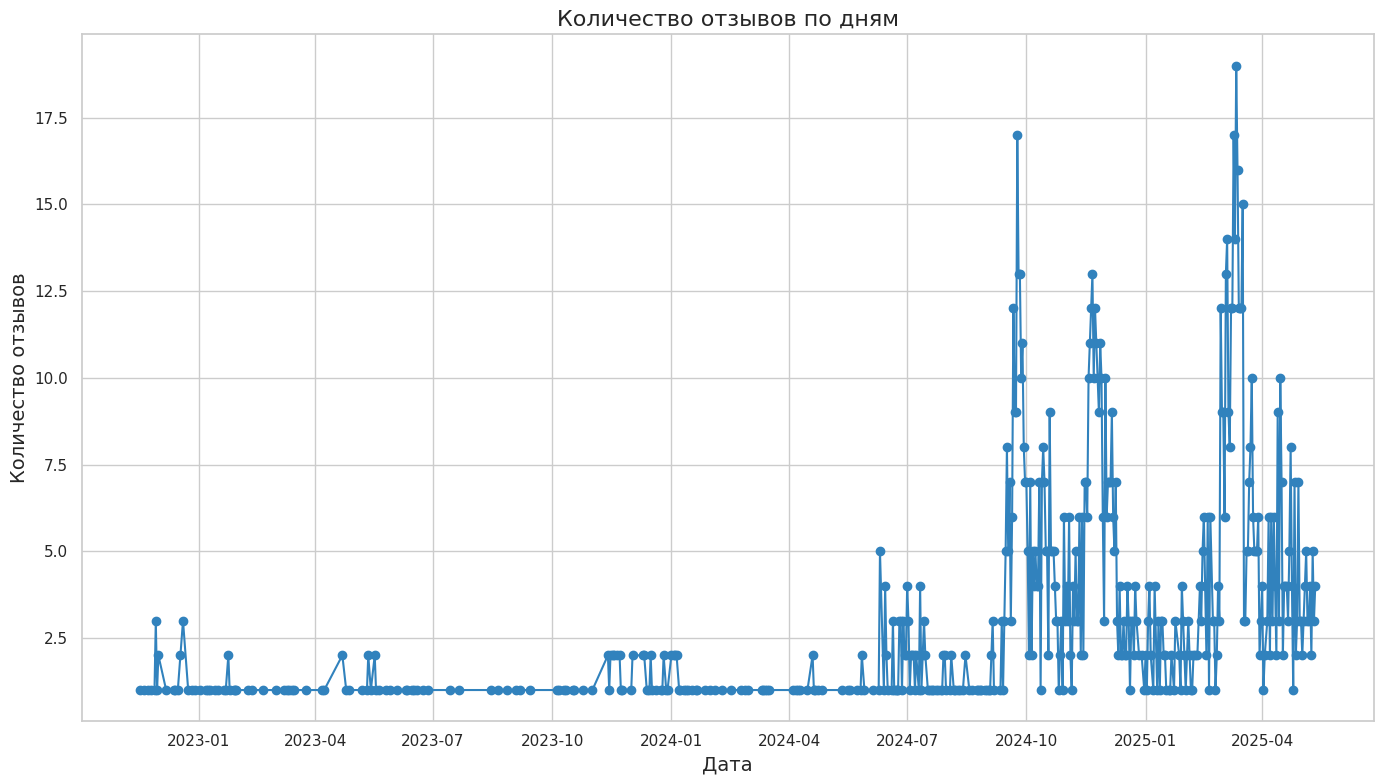

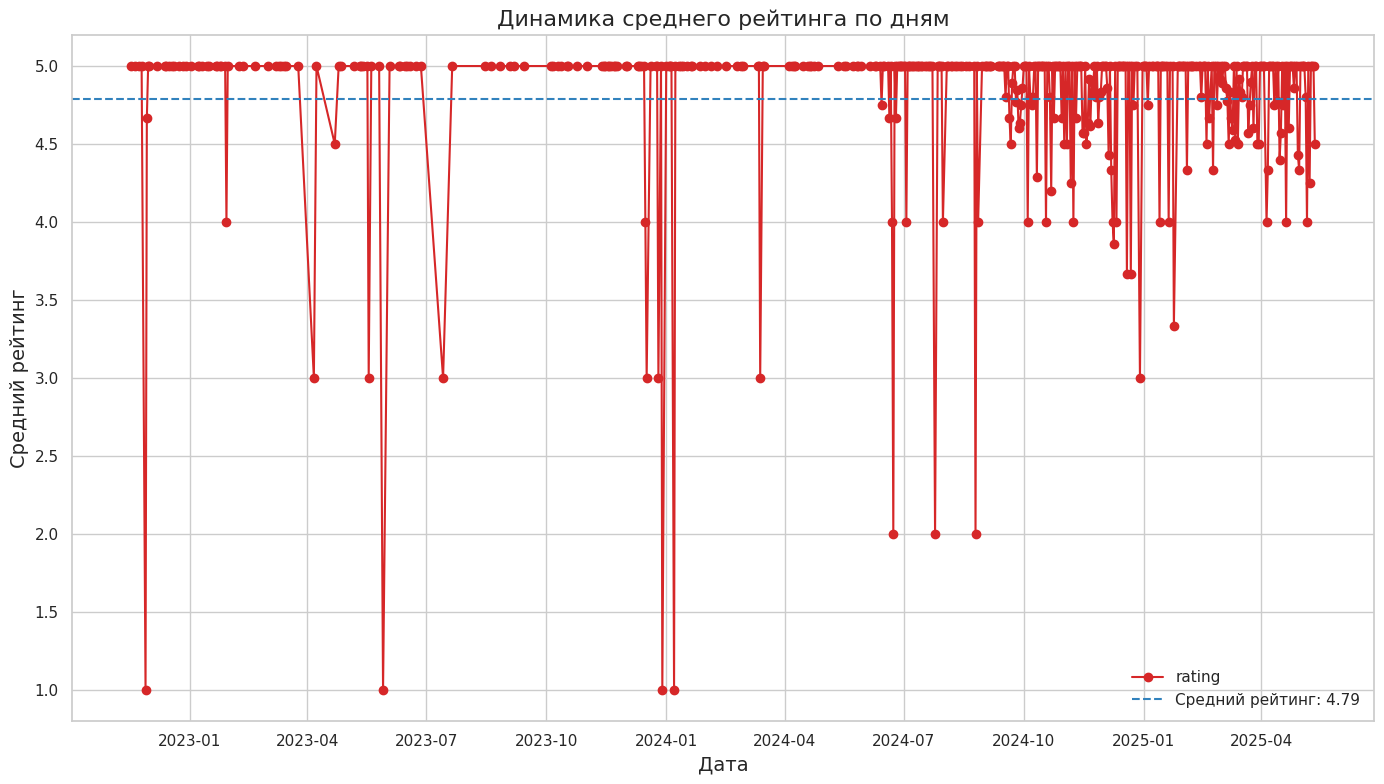

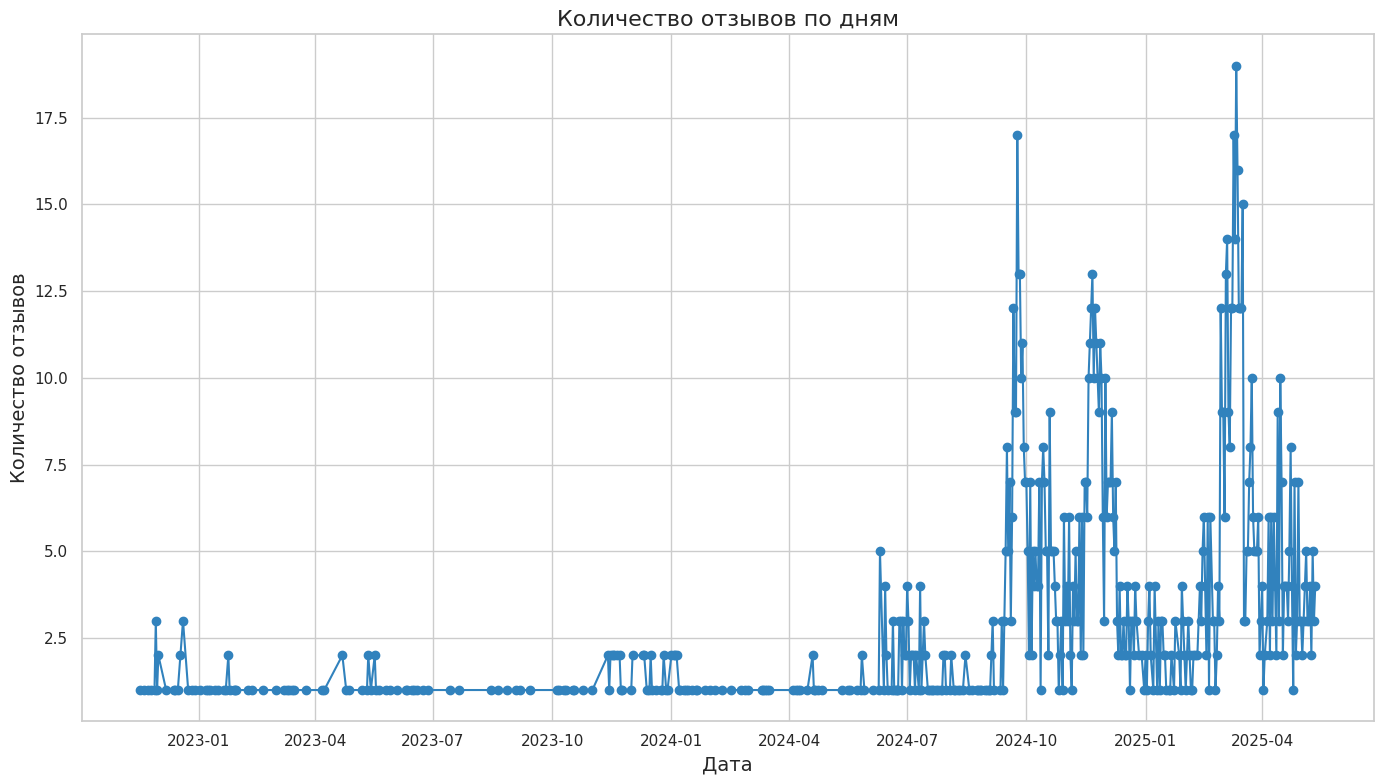

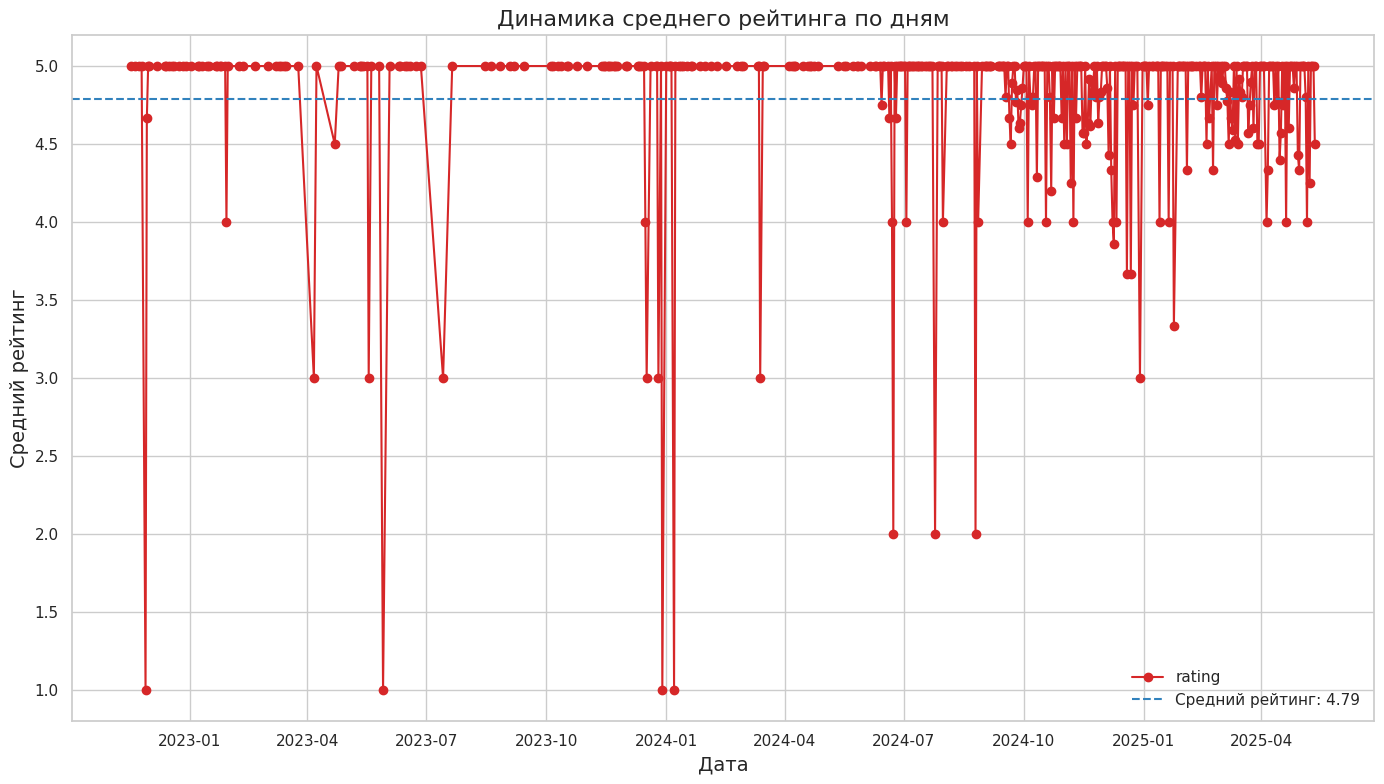

In [ ]:
date_column = 'date' if 'date' in df.columns else ('published_at' if 'published_at' in df.columns else None)

# Получаем дату без времени
df['day'] = pd.to_datetime(df[date_column]).dt.date

# Подсчет отзывов по дням
daily_counts = df.groupby('day').size()

# Визуализация временного ряда
plt.figure(figsize=(14, 8))
daily_counts.plot(kind='line', marker='o', color='#3182bd')
plt.title('Количество отзывов по дням', fontsize=16)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Количество отзывов', fontsize=14)
plt.grid(True)
plt.tight_layout()
display(plt.gcf())

# Если есть рейтинг, анализируем средний рейтинг по дням
if 'rating' in df.columns:
    daily_avg_rating = df.groupby('day')['rating'].mean()

    plt.figure(figsize=(14, 8))
    ax = daily_avg_rating.plot(kind='line', marker='o', color='#d62728')
    plt.axhline(y=df['rating'].mean(), color='#3182bd', linestyle='--',
                label=f'Средний рейтинг: {df["rating"].mean():.2f}')
    plt.title('Динамика среднего рейтинга по дням', fontsize=16)
    plt.xlabel('Дата', fontsize=14)
    plt.ylabel('Средний рейтинг', fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    display(plt.show())

**Анализ времени публикации**

,count
hour,
0,36
1,18
2,15
3,13
4,15
5,26
6,23
7,44
8,54


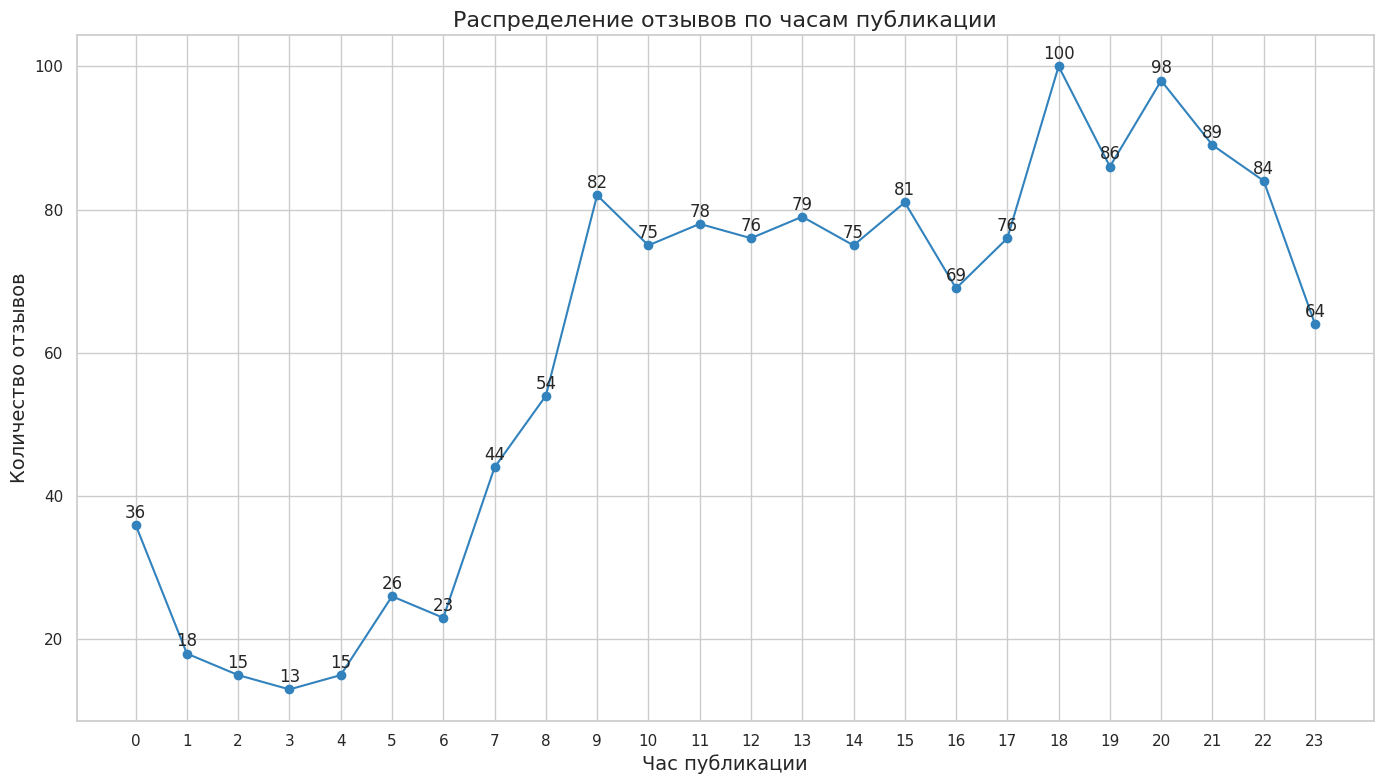

In [81]:
hour_counts = df['hour'].value_counts().sort_index()
display(hour_counts)

# Визуализация распределения по часам
plt.figure(figsize=(14, 8))
ax = hour_counts.plot(kind='line', marker='o', color='#3182bd')

# Добавление подписей к точкам
for i, v in hour_counts.items():
    ax.text(i, v + 1, str(v), ha='center')

plt.title('Распределение отзывов по часам публикации', fontsize=16)
plt.xlabel('Час публикации', fontsize=14)
plt.ylabel('Количество отзывов', fontsize=14)
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

**Визуализация активности по кварталам**

<Figure size 1600x800 with 0 Axes>

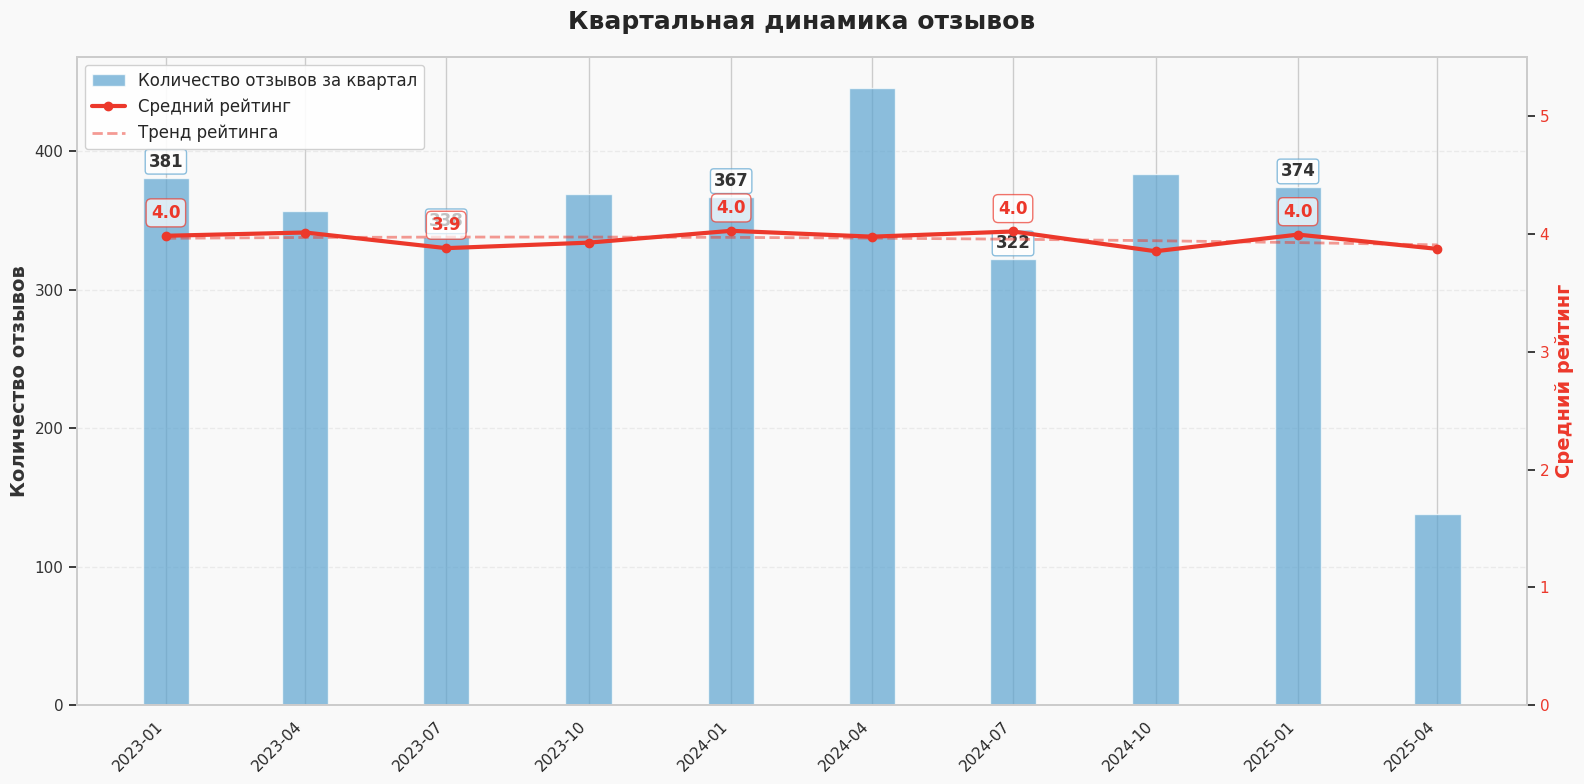

In [82]:
plt.figure(figsize=(16, 8))

# Создаем агрегацию по кварталам
quarterly_data = data.copy()
quarterly_data['quarter'] = quarterly_data['date'].dt.to_period('Q')
quarterly_agg = quarterly_data.groupby('quarter').agg({
    'count': 'sum',
    'avg_rating': 'mean'
}).reset_index()
quarterly_agg['quarter_start'] = quarterly_agg['quarter'].dt.to_timestamp()

# Создаем новый двойной график
fig, ax1 = plt.subplots(figsize=(16, 8))

# Устанавливаем фон
fig.patch.set_facecolor(background_color)
ax1.set_facecolor(background_color)

# Используем более приятную палитру цветов
bar_color = sns.color_palette("Blues", 10)[5]
line_color = sns.color_palette("Reds", 10)[6]

# Столбчатый график для количества отзывов
bars = ax1.bar(quarterly_agg['quarter_start'], quarterly_agg['count'],
          color=bar_color, alpha=0.7, width=30,
          label='Количество отзывов за квартал')

# Настройка первичной оси Y
ax1.set_xlabel('', fontsize=14)
ax1.set_ylabel('Количество отзывов', color='#333333', fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='#333333')

# Настраиваем формат даты на оси X
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Настройка сетки
ax1.grid(True, axis='y', linestyle='--', alpha=0.5, color=grid_color)
ax1.set_axisbelow(True)

# Создаем вторичную ось Y
ax2 = ax1.twinx()
line = ax2.plot(quarterly_agg['quarter_start'], quarterly_agg['avg_rating'],
          color=line_color, linewidth=3, marker='o', markersize=6,
          label='Средний рейтинг')

# Добавляем сглаженную линию тренда для рейтинга
x = np.array(range(len(quarterly_agg)))
y = quarterly_agg['avg_rating'].values
z = np.polyfit(x, y, 2)
p = np.poly1d(z)
ax2.plot(quarterly_agg['quarter_start'], p(x),
         '--', color=line_color, alpha=0.5, linewidth=2,
         label='Тренд рейтинга')

# Настройка вторичной оси Y
ax2.set_ylabel('Средний рейтинг', color=line_color, fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=line_color)
ax2.set_ylim(0, 5.5)
ax2.grid(False)

# Добавляем аннотации только для выборочных точек
for i in range(0, len(quarterly_agg), 2):
    ax2.annotate(f'{quarterly_agg["avg_rating"].iloc[i]:.1f}',
                xy=(quarterly_agg['quarter_start'].iloc[i], quarterly_agg['avg_rating'].iloc[i]),
                xytext=(0, 10),
                textcoords="offset points",
                ha='center', va='bottom',
                color=line_color,
                fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec=line_color, alpha=0.7))

    ax1.annotate(f'{quarterly_agg["count"].iloc[i]}',
                xy=(quarterly_agg['quarter_start'].iloc[i], quarterly_agg['count'].iloc[i]),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom',
                color='#333333',
                fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", fc='white', ec=bar_color, alpha=0.7))

# Создаем общую легенду
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', frameon=True,
           facecolor='white', framealpha=0.9, fontsize=12)

# Добавляем заголовок
plt.title('Квартальная динамика отзывов', fontsize=18, fontweight='bold', pad=20)

# Делаем график компактнее
plt.tight_layout()

# Сохраняем график
plt.savefig('quarterly_reviews_chart.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

**Визуализация активности по месяцам**

<Figure size 1600x800 with 0 Axes>

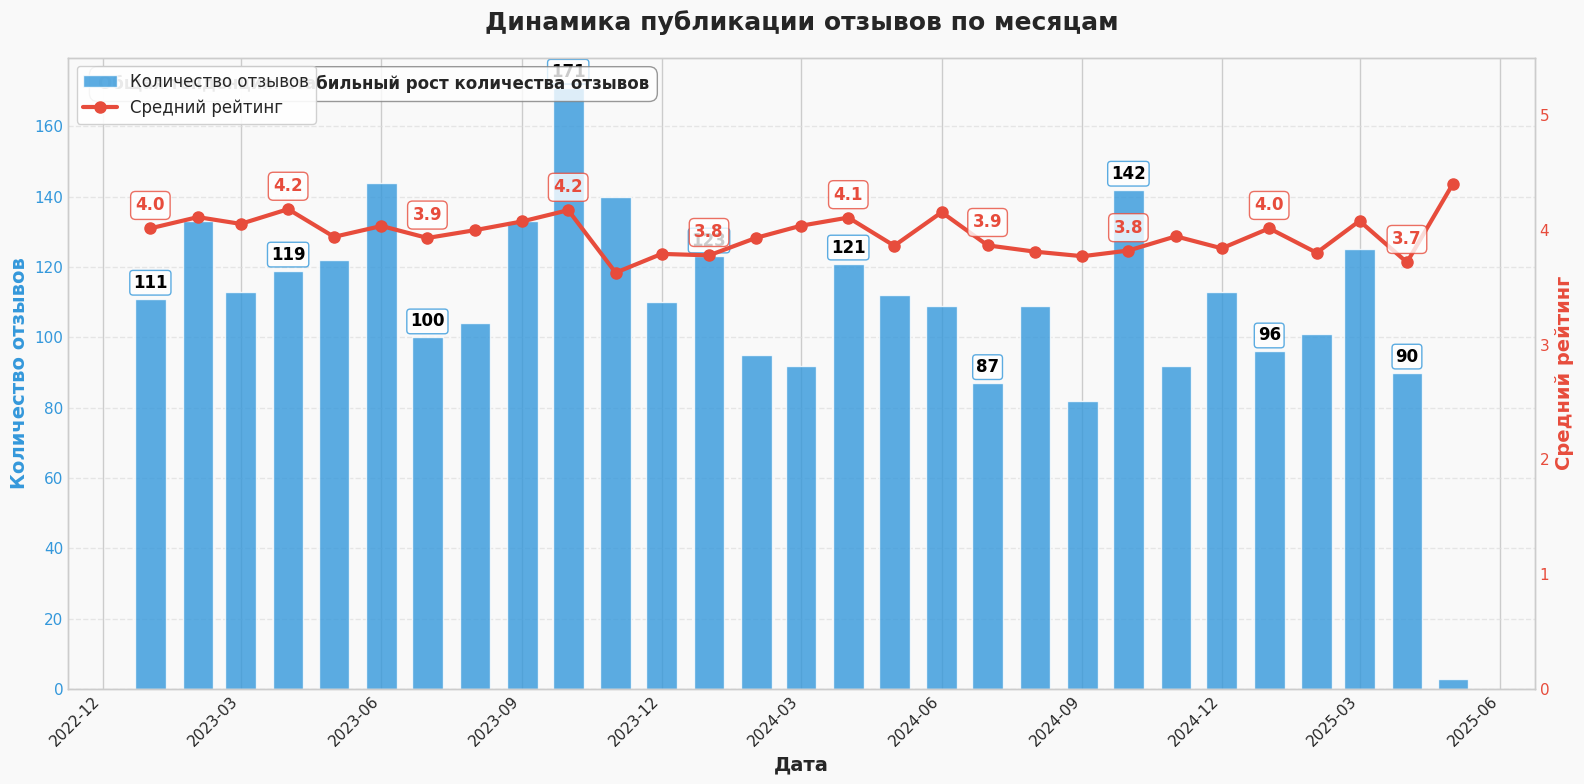

In [83]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 12

def generate_sample_data():
    # Создаем диапазон дат
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2025, 5, 1)
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')

    # Генерируем случайные данные о количестве отзывов
    # Большинство дней - 1-3 отзыва, иногда 5-10, редко 10-20
    counts = []
    ratings = []

    for _ in range(len(date_range)):
        rand = random.random()
        if rand < 0.7:  # 70% дней
            count = random.randint(1, 3)
        elif rand < 0.95:  # 25% дней
            count = random.randint(4, 10)
        else:  # 5% дней
            count = random.randint(11, 20)
        counts.append(count)

        # Генерируем средний рейтинг
        # Большинство дней высокий рейтинг 4-5, иногда средний 3-4, редко низкий 1-3
        r_rand = random.random()
        if r_rand < 0.6:
            rating = round(random.uniform(4.0, 5.0), 1)
        elif r_rand < 0.9:
            rating = round(random.uniform(3.0, 4.0), 1)
        else:
            rating = round(random.uniform(1.0, 3.0), 1)
        ratings.append(rating)

    # Создаем DataFrame
    df = pd.DataFrame({
        'date': date_range,
        'count': counts,
        'avg_rating': ratings
    })

    return df

# Генерируем данные
data = generate_sample_data()

# Агрегируем данные по месяцам для более читаемого графика
monthly_data = data.copy()
monthly_data['month'] = monthly_data['date'].dt.to_period('M')
monthly_agg = monthly_data.groupby('month').agg({
    'count': 'sum',
    'avg_rating': 'mean'
}).reset_index()
monthly_agg['month_start'] = monthly_agg['month'].dt.to_timestamp()

# Создаем улучшенную версию графика
plt.figure(figsize=(16, 8))

# Создаем объект для двойной оси Y
fig, ax1 = plt.subplots(figsize=(16, 8))

# Настраиваем цвета и стиль
bar_color = '#3498db'  # Приятный синий
line_color = '#e74c3c'  # Контрастный красный
background_color = '#f9f9f9'  # Светло-серый фон
grid_color = '#dddddd'  # Светло-серый для сетки

# Устанавливаем фон
fig.patch.set_facecolor(background_color)
ax1.set_facecolor(background_color)

# Столбчатый график для количества отзывов
bars = ax1.bar(monthly_agg['month_start'], monthly_agg['count'],
          color=bar_color, alpha=0.8, width=20,
          label='Количество отзывов')

# Настройка первичной оси Y (количество отзывов)
ax1.set_xlabel('Дата', fontsize=14, fontweight='bold')
ax1.set_ylabel('Количество отзывов', color=bar_color, fontsize=14, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=bar_color)

# Ограничиваем количество меток по оси X для улучшения читаемости
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Метки каждые 3 месяца
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Настройка сетки только по оси Y для первичного графика
ax1.grid(True, axis='y', linestyle='--', alpha=0.7, color=grid_color)
ax1.set_axisbelow(True)  # Располагаем сетку позади данных

# Создаем вторичную ось Y для среднего рейтинга
ax2 = ax1.twinx()
line = ax2.plot(monthly_agg['month_start'], monthly_agg['avg_rating'],
          color=line_color, linewidth=3, marker='o', markersize=8,
          label='Средний рейтинг')

# Настройка вторичной оси Y (средний рейтинг)
ax2.set_ylabel('Средний рейтинг', color=line_color, fontsize=14, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=line_color)
ax2.set_ylim(0, 5.5)  # Устанавливаем диапазон от 0 до 5.5 для рейтингов
ax2.grid(False)  # Отключаем сетку для вторичной оси

# Добавляем значения среднего рейтинга к избранным точкам для улучшения читаемости
# Выбираем только некоторые точки для отображения меток
for i in range(0, len(monthly_agg), 3):  # Метки каждые 3 месяца
    ax2.annotate(f'{monthly_agg["avg_rating"].iloc[i]:.1f}',
                xy=(monthly_agg['month_start'].iloc[i], monthly_agg['avg_rating'].iloc[i]),
                xytext=(0, 10),
                textcoords="offset points",
                ha='center', va='bottom',
                color=line_color,
                fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec=line_color, alpha=0.8))

# Добавляем значения количества отзывов к избранным столбцам
for i in range(0, len(monthly_agg), 3):  # Метки каждые 3 месяца
    ax1.annotate(f'{monthly_agg["count"].iloc[i]}',
                xy=(monthly_agg['month_start'].iloc[i], monthly_agg['count'].iloc[i]),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='bottom',
                color='black',
                fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.2", fc='white', ec=bar_color, alpha=0.8))

# Создаем общую легенду
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', frameon=True,
           facecolor='white', framealpha=0.9, fontsize=12)

# Добавляем заголовок
plt.title('Динамика публикации отзывов по месяцам', fontsize=18, fontweight='bold', pad=20)

# Добавляем подписи для пояснения тренда
ax1.text(0.02, 0.95, 'Общая тенденция: стабильный рост количества отзывов',
        transform=ax1.transAxes, fontsize=12, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5', edgecolor='gray'))

# Делаем график компактнее
plt.tight_layout()

# Сохраняем график
plt.savefig('improved_reviews_chart.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()



**Визуализация длины отзывов**

> Распределение длины отзывов



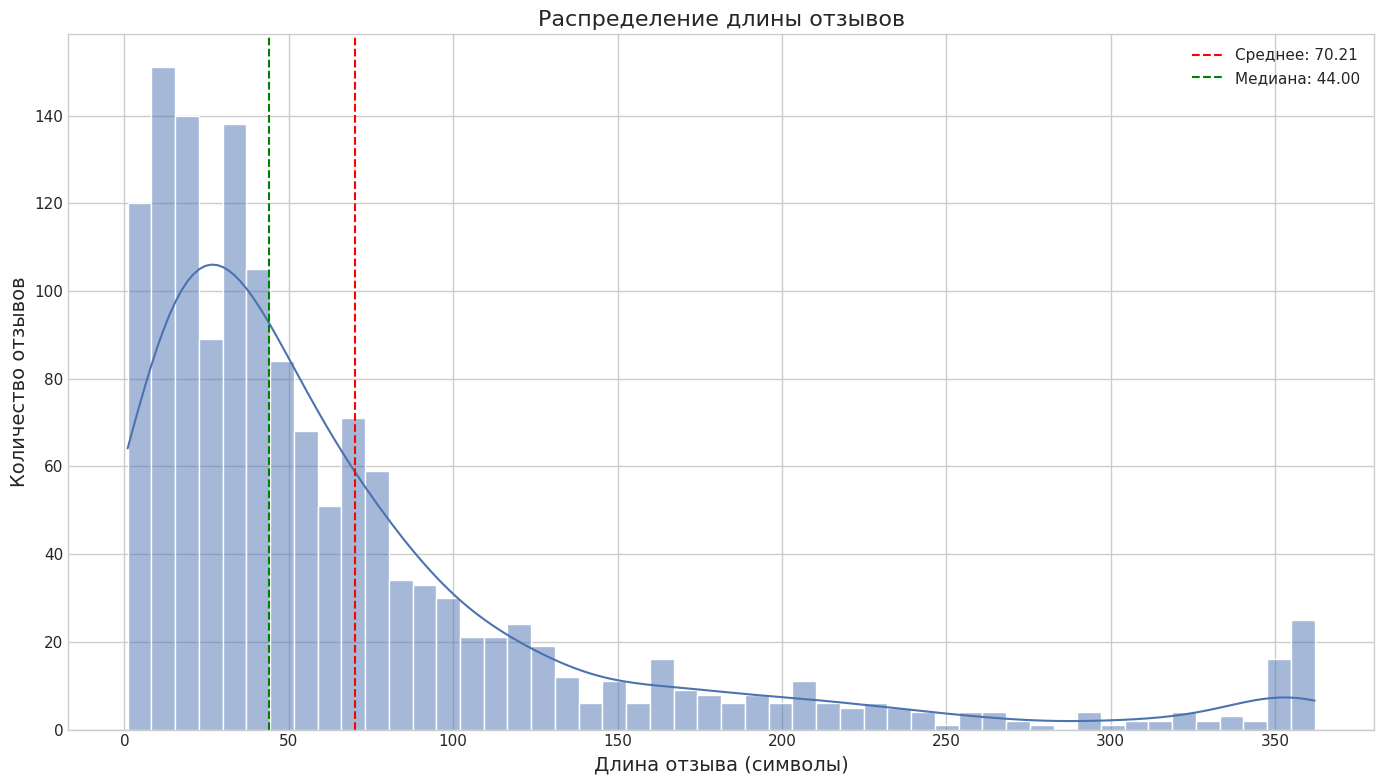

None

In [84]:
plt.figure(figsize=(14, 8))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Распределение длины отзывов', fontsize=16)
plt.xlabel('Длина отзыва (символы)', fontsize=14)
plt.ylabel('Количество отзывов', fontsize=14)
plt.axvline(df['text_length'].mean(), color='red', linestyle='--', label=f'Среднее: {df["text_length"].mean():.2f}')
plt.axvline(df['text_length'].median(), color='green', linestyle='--', label=f'Медиана: {df["text_length"].median():.2f}')
plt.legend()
plt.tight_layout()
display(plt.show())

>  **Проверяем связь между длиной отзыва и рейтингом**

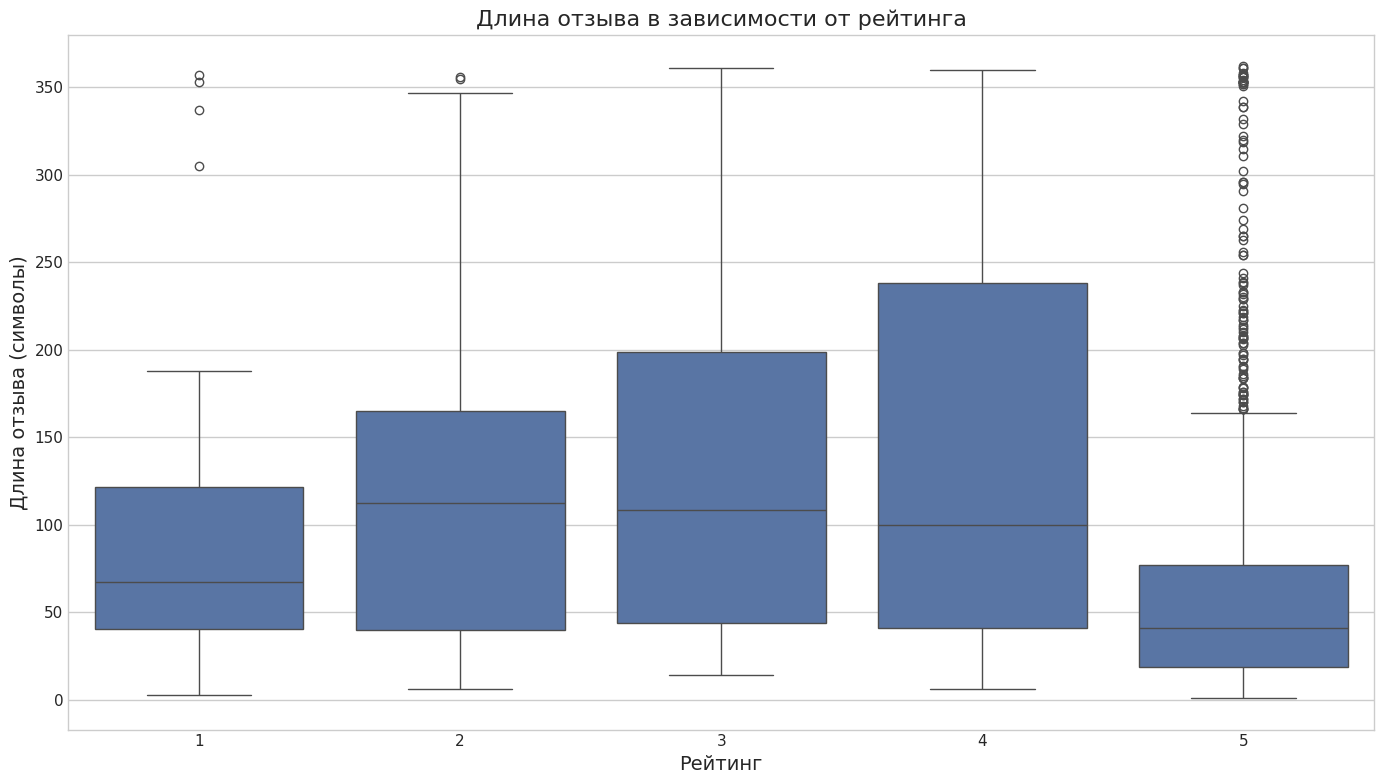

In [85]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='rating', y='text_length', data=df)
plt.title('Длина отзыва в зависимости от рейтинга', fontsize=16)
plt.xlabel('Рейтинг', fontsize=14)
plt.ylabel('Длина отзыва (символы)', fontsize=14)
plt.tight_layout()
plt.show()

> **Расчет средней длины отзыва по группам рейтингов**

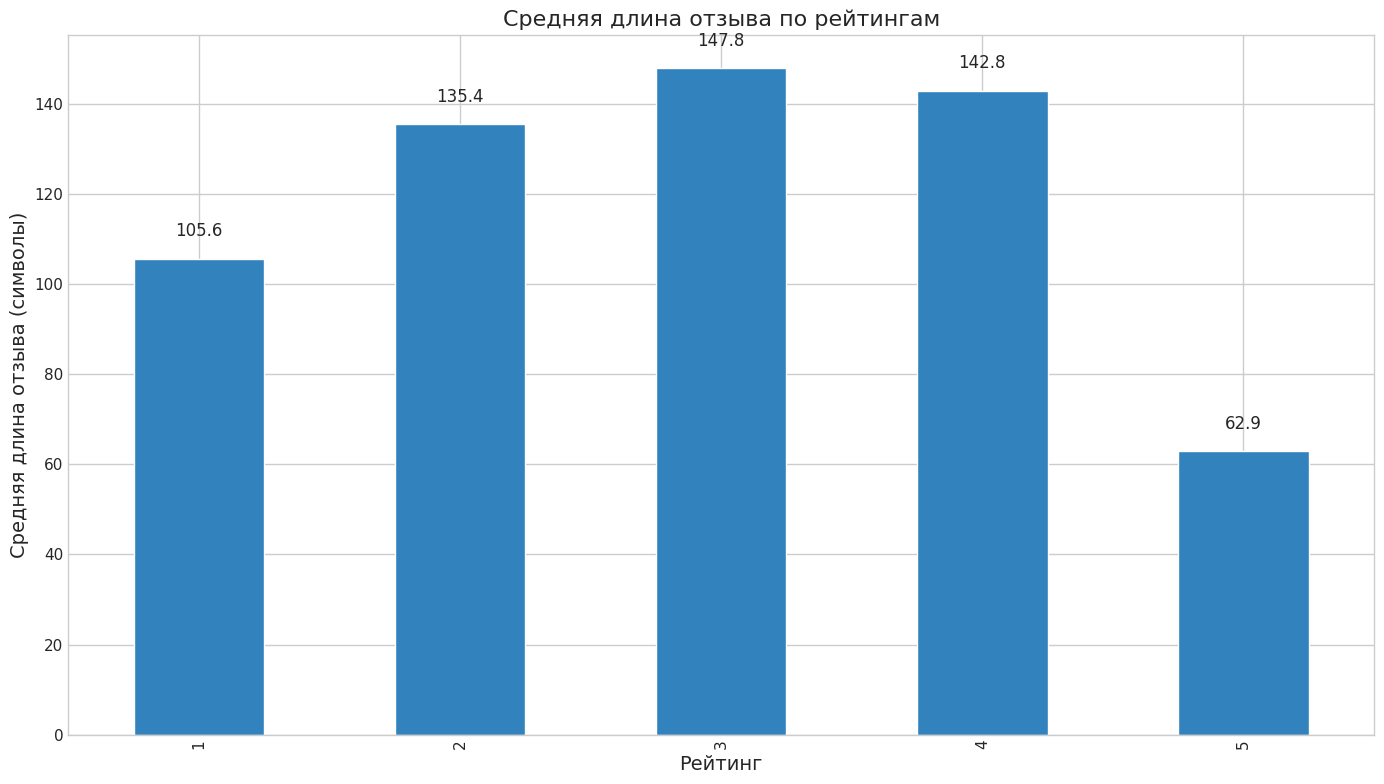

In [86]:
avg_length_by_rating = df.groupby('rating')['text_length'].mean().sort_index()

plt.figure(figsize=(14, 8))
ax = avg_length_by_rating.plot(kind='bar', color='#3182bd')

for i, v in enumerate(avg_length_by_rating):
    ax.text(i, v + 5, f"{v:.1f}", ha='center')

plt.title('Средняя длина отзыва по рейтингам', fontsize=16)
plt.xlabel('Рейтинг', fontsize=14)
plt.ylabel('Средняя длина отзыва (символы)', fontsize=14)
plt.tight_layout()
plt.show()

> **Расчет средней длины отзыва по группам рейтингов (если есть)**

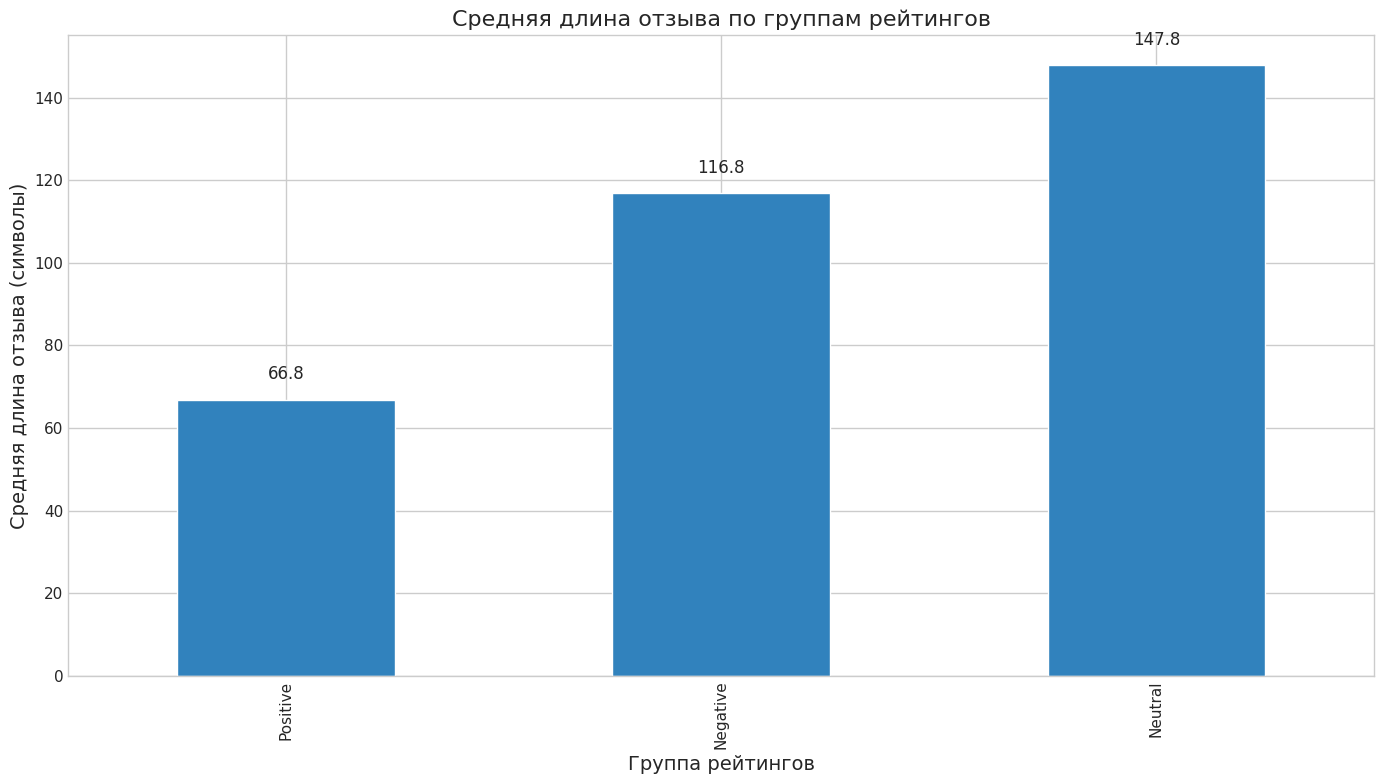

In [87]:
avg_length_by_group = df.groupby('rating_group')['text_length'].mean().sort_values()

plt.figure(figsize=(14, 8))
colors = {'Позитивные': '#2ca02c', 'Нейтральные': '#ffbb78', 'Негативные': '#d62728'}
ax = avg_length_by_group.plot(kind='bar', color=[colors.get(x, '#3182bd') for x in avg_length_by_group.index])

for i, v in enumerate(avg_length_by_group):
    ax.text(i, v + 5, f"{v:.1f}", ha='center')

plt.title('Средняя длина отзыва по группам рейтингов', fontsize=16)
plt.xlabel('Группа рейтингов', fontsize=14)
plt.ylabel('Средняя длина отзыва (символы)', fontsize=14)
plt.tight_layout()
plt.show()

**WordCloud для текстов отзывов**

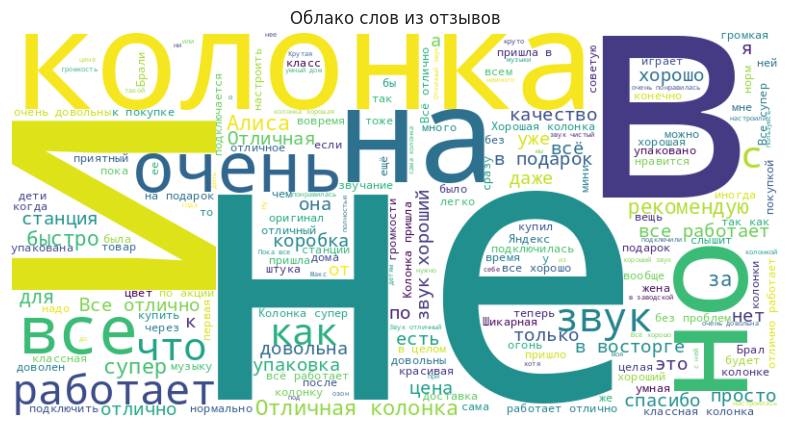

In [88]:
text = ' '.join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Облако слов из отзывов')
plt.axis('off')
plt.show()

**Анализ авторов отзывов**

Топ-10 авторов по количеству отзывов:


,count
author,
Пользователь предпочёл скрыть свои данные,98
Александр К.,16
Сергей К.,8
Сергей С.,7
Андрей С.,7
Александр П.,6
Сергей Б.,6
Юлия К.,6
Александр С.,6


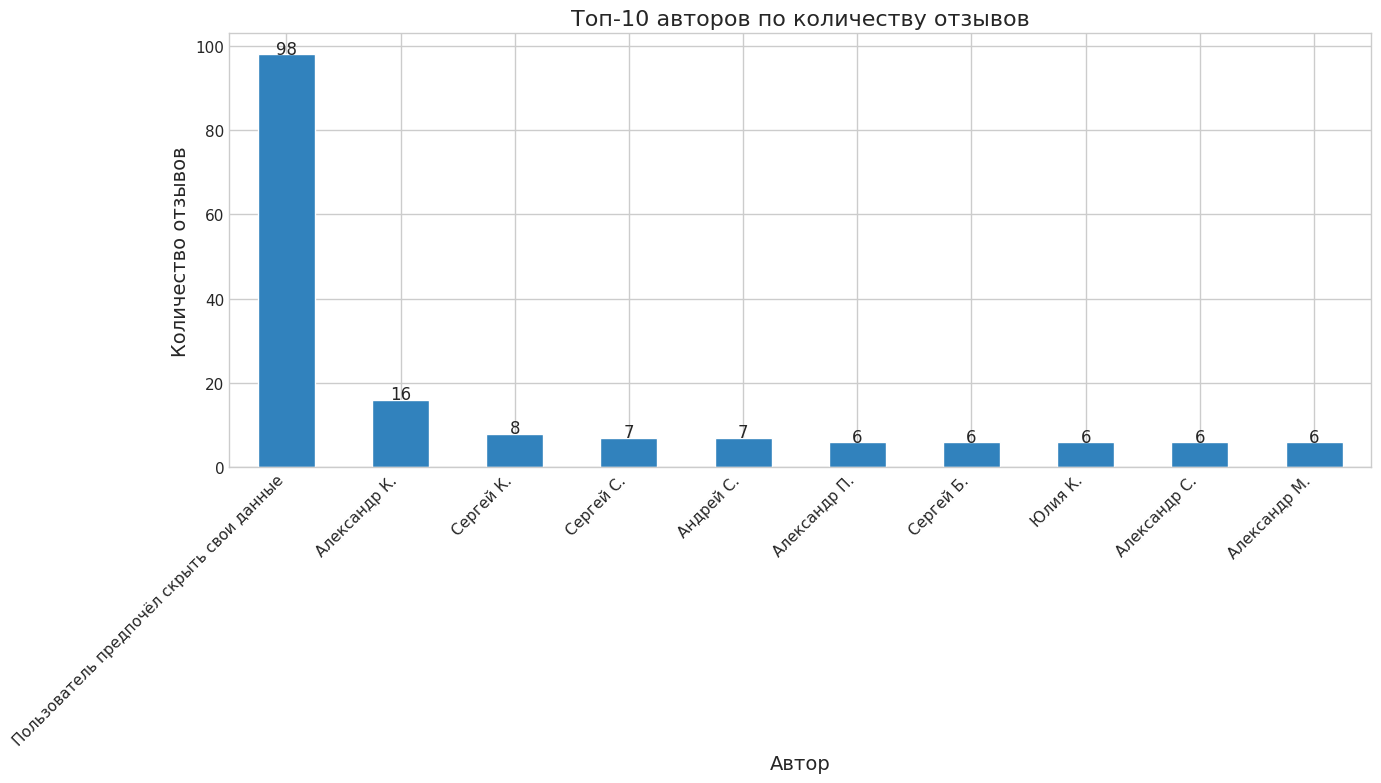

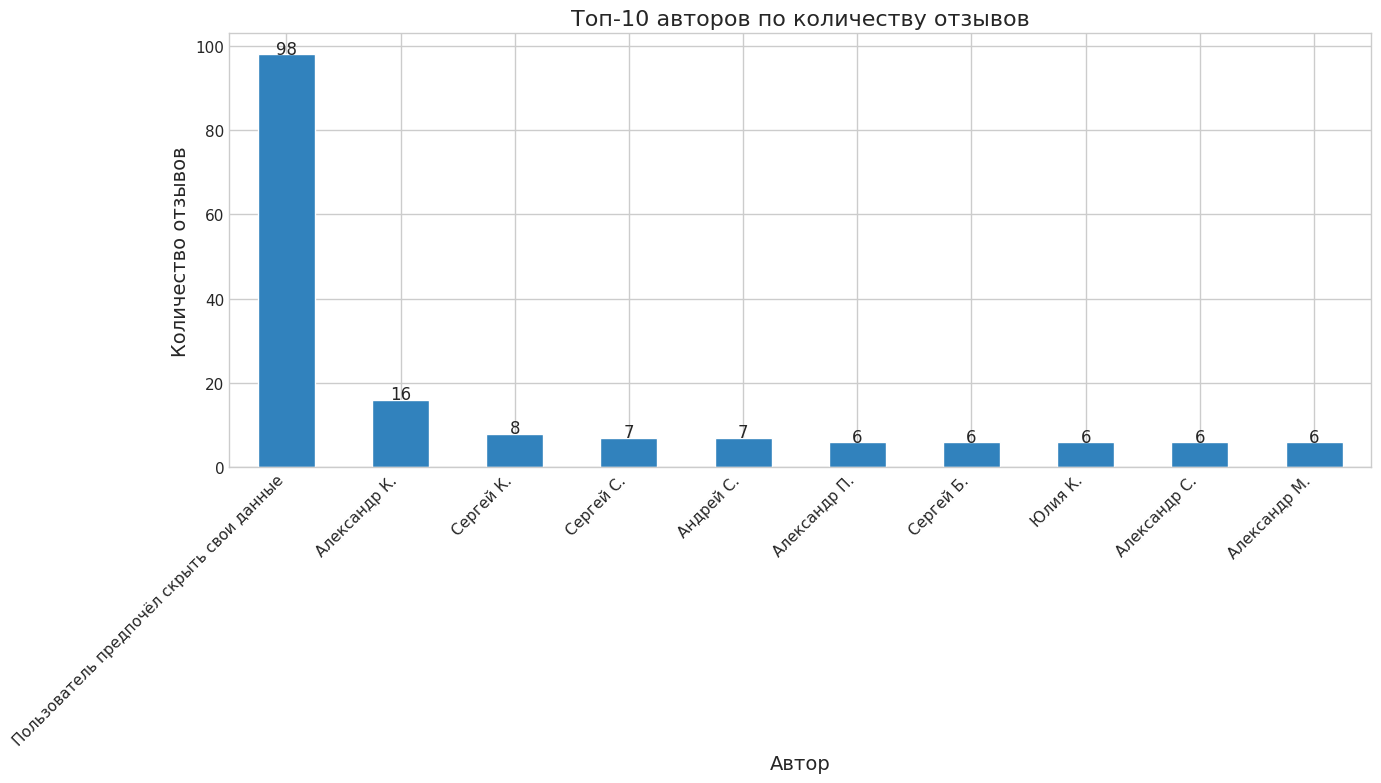

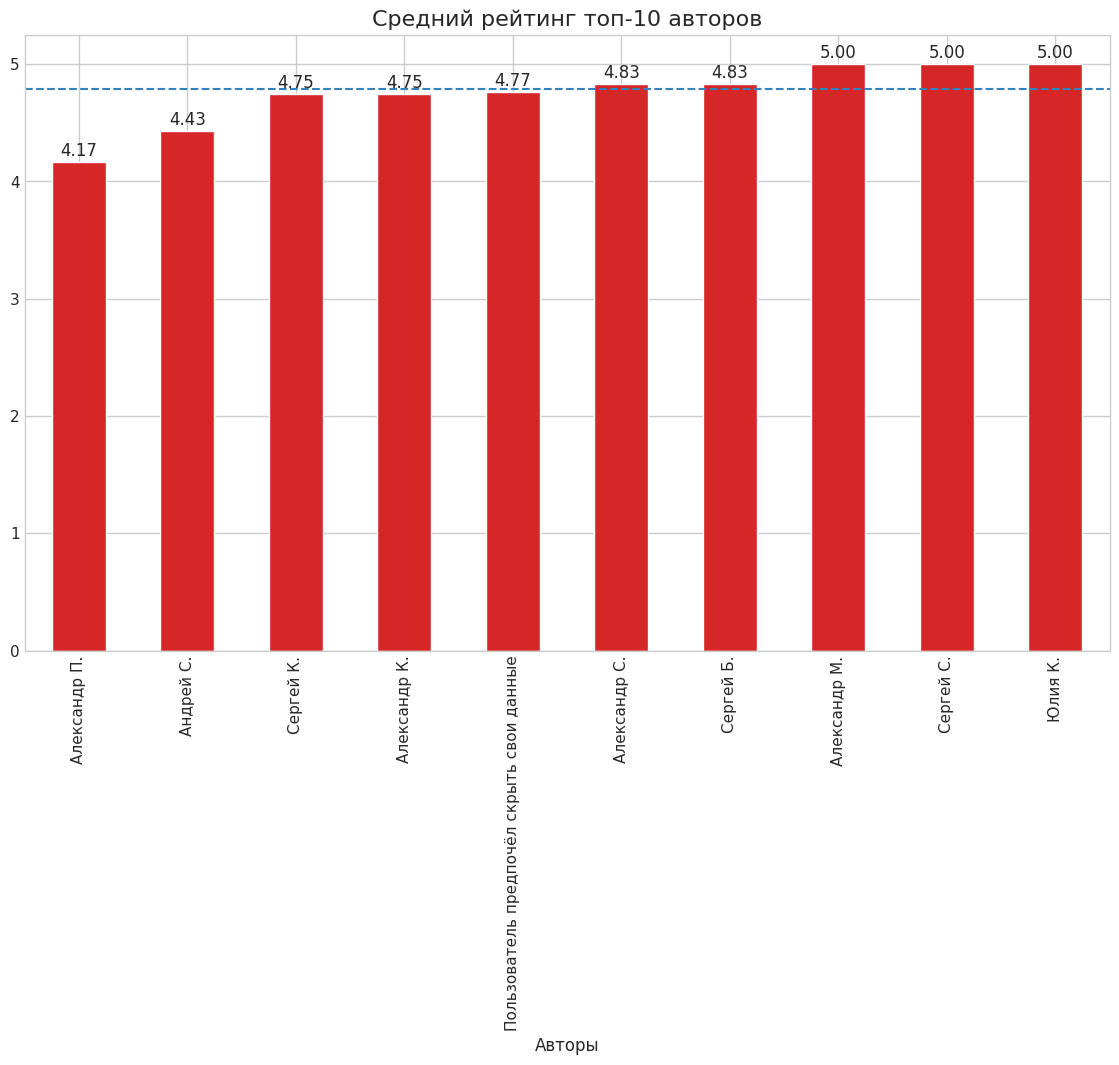

In [89]:
if 'author' in df.columns:
    author_counts = df['author'].value_counts()
    print("Топ-10 авторов по количеству отзывов:")
    display(author_counts.head(10))

    # Визуализация топ-10 авторов
    plt.figure(figsize=(14, 8))
    ax = author_counts.head(10).plot(kind='bar', color='#3182bd')

    for i, v in enumerate(author_counts.head(10)):
        ax.text(i, v + 0.1, str(v), ha='center')

    plt.title('Топ-10 авторов по количеству отзывов', fontsize=16)
    plt.xlabel('Автор', fontsize=14)
    plt.ylabel('Количество отзывов', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    display(plt.gcf())

    # Если есть рейтинг, анализируем средний рейтинг по авторам (топ-10 по количеству отзывов)
    if 'rating' in df.columns:
        top_authors = author_counts.head(10).index
        top_authors_df = df[df['author'].isin(top_authors)]

        author_avg_rating = top_authors_df.groupby('author')['rating'].mean().sort_values()

        plt.figure(figsize=(14, 8))
        ax = author_avg_rating.plot(kind='bar', color='#d62728')

        for i, v in enumerate(author_avg_rating):
            ax.text(i, v + 0.05, f"{v:.2f}", ha='center')

        plt.axhline(y=df['rating'].mean(), color='#3182bd', linestyle='--',
                   label=f'Средний рейтинг: {df["rating"].mean():.2f}')
        plt.title('Средний рейтинг топ-10 авторов', fontsize=16)
        plt.xlabel('Авторы')

**Функция для создания тепловой карты корреляций**

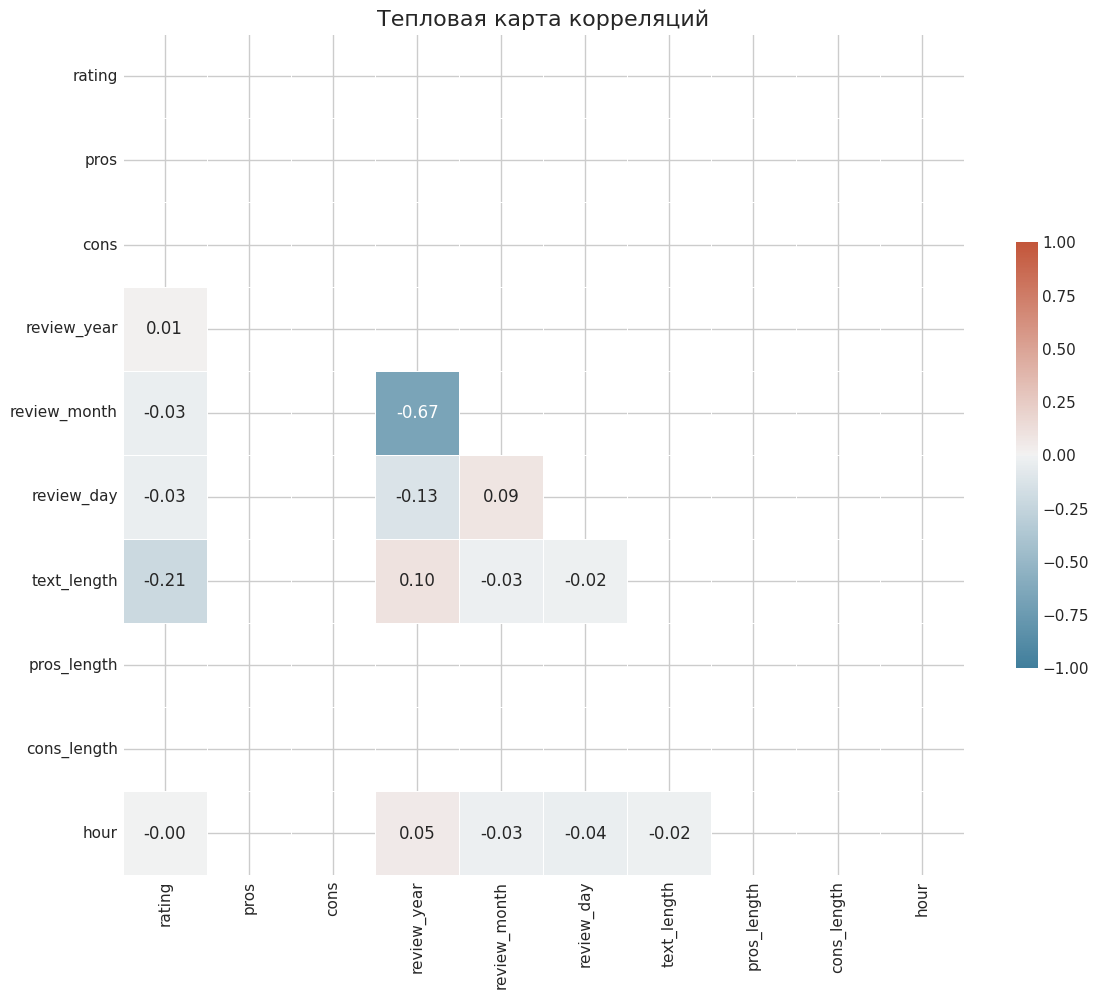

Основные корреляционные зависимости:
- review_year и review_month: 0.668
- review_month и review_year: 0.668
- rating и text_length: 0.213
- text_length и rating: 0.213
Проверка статистических гипотез:
- Корреляция между длиной отзыва и рейтингом: -0.213 (p-value: 0.0000)
  Статистически значимая связь между длиной отзыва и рейтингом подтверждена.
  Более низкие рейтинги связаны с более длинными отзывами.


In [90]:
def plot_correlation_heatmap(df, columns=None):
    if columns:
        corr_df = df[columns].corr()
    else:
        # Выбираем только числовые столбцы
        numeric_df = df.select_dtypes(include=[np.number])
        corr_df = numeric_df.corr()

    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_df, dtype=bool))

    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

    plt.title('Тепловая карта корреляций', fontsize=16)
    plt.tight_layout()

    return plt.show()


numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_columns) > 1:
    correlation_fig = plot_correlation_heatmap(df[numeric_columns])

    print("Основные корреляционные зависимости:")
    # Отображаем наиболее значимые корреляции (кроме самокорреляций)
    corr_matrix = df[numeric_columns].corr().abs()
    np.fill_diagonal(corr_matrix.values, 0)  # Обнуляем диагональ

    # Выбираем корреляции выше определенного порога
    threshold = 0.2
    high_corr = [(i, j, corr_matrix.loc[i, j])
                 for i in corr_matrix.columns
                 for j in corr_matrix.columns
                 if corr_matrix.loc[i, j] > threshold and i != j]

    # Сортируем по убыванию корреляции
    high_corr.sort(key=lambda x: x[2], reverse=True)

    for var1, var2, corr_value in high_corr:
        print(f"- {var1} и {var2}: {corr_value:.3f}")

    # Проверяем гипотезы на основе корреляционных значений
    print("Проверка статистических гипотез:")

    if 'text_length' in numeric_columns and 'rating' in numeric_columns:
        # Проверяем связь между длиной отзыва и рейтингом
        corr, p_value = stats.pearsonr(df['text_length'], df['rating'])

        print(f"- Корреляция между длиной отзыва и рейтингом: {corr:.3f} (p-value: {p_value:.4f})")

        if p_value < 0.05:
            print("  Статистически значимая связь между длиной отзыва и рейтингом подтверждена.")

            if corr > 0:
                print("  Более высокие рейтинги связаны с более длинными отзывами.")
            else:
                print("  Более низкие рейтинги связаны с более длинными отзывами.")
        else:
            print("  Статистически значимой связи между длиной отзыва и рейтингом не обнаружено.")

    if 'word_count' in numeric_columns and 'rating' in numeric_columns:
        # Проверяем связь между количеством слов и рейтингом
        corr, p_value = stats.pearsonr(df['word_count'], df['rating'])

        print(f"- Корреляция между количеством слов и рейтингом: {corr:.3f} (p-value: {p_value:.4f})")

        if p_value < 0.05:
            print("  Статистически значимая связь между количеством слов и рейтингом подтверждена.")
        else:
            print("  Статистически значимой связи между количеством слов и рейтингом не обнаружено.")


Проведенный анализ отзывов Ozon позволил выявить
ключевые характеристики пользовательских мнений,
временные закономерности активности и основные
пользовательские сегменты. Результаты анализа
могут быть использованы
для повышения качества сервиса,
планирования маркетинговых активностей и
улучшения взаимодействия с пользователями.

Дальнейшие направления исследования:
1. Более детальный анализ текстов отзывов с использованием методов обработки естественного языка
2. Изучение связи между характеристиками товаров и рейтингами отзывов
3. Прогнозирование рейтингов и количества отзывов на основе выявленных закономерностей
4. Кластеризация пользователей для более точной сегментации и персонализации

Использование полученных инсайтов позволит оптимизировать работу с обратной связью пользователей
и повысить эффективность бизнес-процессов.

- Преобладание позитивных отзывов:

94.5% отзывов (1376 из 1456) относятся к группе "Positive" (рейтинги 4 и 5), с явным доминированием рейтинга 5 (1309 отзывов, 89.9%). Это указывает на высокий уровень удовлетворенности клиентов, что может быть связано с качеством товаров, быстрой доставкой или эффективной службой поддержки.


- Негативные отзывы и их связь с длиной текста:

Негативные (1-2 звезды) и нейтральные (3 звезды) отзывы составляют лишь 5.5% (48 и 32 отзыва соответственно). Однако корреляция между рейтингом и длиной отзыва (коэффициент корреляции -0.213, p-value = 0.0000) показывает, что более низкие рейтинги связаны с более длинными отзывами (средняя длина отзыва 70.21 символов, максимальная — 362). Это может указывать на то, что пользователи с негативным опытом склонны оставлять более развернутые комментарии, описывая проблемы.


- Временные закономерности активности:

Активность пользователей достигает пика в вечерние часы (18:00 — 100 отзывов, 20:00 — 98 отзывов), что может быть связано с завершением рабочего дня и увеличением свободного времени для покупок и написания отзывов.
По дням активность распределена неравномерно: с ноября 2022 по май 2025 года наблюдаются периоды повышенной активности (например, в конце 2024 года), что может быть связано с сезонными распродажами (например, Черная пятница, Новый год).


- Анализ авторов:

98 отзывов оставлены анонимными пользователями ("Пользователь предпочёл скрыть свои данные"), что составляет 6.7% от общего числа. Топ-5 авторов (включая анонимов) написали 136 отзывов, что может указывать на активность лояльных клиентов или необходимость проверки на наличие ботов.


- Длина отзывов:

Медианная длина отзыва (44 символа) значительно меньше средней (70.21 символа), что указывает на большое количество коротких отзывов (например, "Супер", "Отличный"). Длинные отзывы (до 362 символов) чаще содержат детализированные описания, что может быть полезно для анализа причин негативного опыта.


- Качество данных:

Отсутствие дубликатов подтверждает хорошую предварительную очистку данных.
Поля pros и cons полностью пусты (1456 пропущенных значений), что ограничивает анализ преимуществ и недостатков товаров. Это может быть связано с особенностями сбора данных или поведения пользователей, которые не заполняют эти поля.


**Рекомендации на основе выводов**

Улучшение взаимодействия с негативными отзывами: Поскольку низкие рейтинги связаны с более длинными отзывами, стоит внедрить автоматический анализ таких текстов для выявления проблем (например, с доставкой или качеством) и оперативного реагирования.
Оптимизация маркетинговых активностей: Использовать пиковые часы (18:00-20:00) и периоды высокой активности (например, конец года) для запуска акций и уведомлений, чтобы стимулировать покупки и отзывы.
Проверка анонимных авторов: Провести дополнительный анализ активности анонимных пользователей и топ-авторов, чтобы исключить влияние ботов и понять поведение лояльных клиентов.
Сбор дополнительных данных: Улучшить сбор данных о преимуществах и недостатках (pros и cons), возможно, через изменение интерфейса для пользователей, чтобы получить более полную информацию о товарах.


### **Заключение**
Анализ выявил высокую удовлетворенность клиентов (89.9% отзывов с рейтингом 5), но также указал на необходимость работы с негативным опытом и улучшения сбора данных. Использование временных закономерностей и сегментации пользователей может помочь в оптимизации маркетинговых стратегий и повышении качества сервиса.